# Projekt MSP1
Cílem tohoto projektu je se seznámit s programovými nástroji využívaných ve statistice a osvojit si základní procedury. Projekt není primárně zaměřen na efektivitu využívání programového vybavení (i když úplně nevhodné konstrukce mohou mít vliv na hodnocení), ale nejvíce nás zajímají vaše statistické závěry a způsob vyhodnocení. Dbejte také na to, že každý graf musí splňovat nějaké podmínky - přehlednost, čitelnost, popisky.

V projektu budete analyzovat časy běhu šesti různých konfigurací algoritmů. Ke každé konfiguraci vzniklo celkem 200 nezávislých běhů, jejichž logy máte k dispozici v souboru [logfiles.zip](logfiles.zip).

Pokud nemáte rozchozené prostředí pro pro spouštění Jupyter notebooku, můžete využití službu [Google Colab](https://colab.google/). Jakákoliv spolupráce, sdílení řešení a podobně je zakázána!

S případnými dotazy se obracejte na Vojtěcha Mrázka (mrazek@fit.vutbr.cz).

__Odevzdání:__ tento soubor (není potřeba aby obsahoval výstupy skriptů) do neděle 22. 10. 2023 v IS VUT. Kontrola bude probíhat na Pythonu 3.10.12; neočekává se však to, že byste používali nějaké speciality a nekompatibilní knihovny. V případě nesouladu verzí a podobných problémů budete mít možnost reklamace a prokázání správnosti funkce. Bez vyplnění vašich komentářů a závěrů do označených buněk nebude projekt hodnocen!

__Upozornění:__ nepřidávejte do notebooku další buňky, odpovídejte tam, kam se ptáme (textové komentáře do Markdown buněk)

__Tip:__ před odevzdáním resetujte celý notebook a zkuste jej spustit od začátku. Zamezíte tak chybám krokování a editací, kdy výsledek z buňky na konci použijete na začátku.

__OTÁZKA K DOPLNĚNÍ:__

_ Jméno a login autora_

David Chocholatý, xchoch09

## Načtení potřebných knihoven
Načtěte knihovny, které jsou nutné pro zpracování souborů a práci se statistickými funkcemi. Není dovoleno načítat jiné knihovny.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from zipfile import ZipFile

## Načtení dat do DataFrame
Ze souboru `logfiles.zip` umístěném ve stejném adresáři načtěte data a vytvořte Pandas DataFrame.

Z logu vás budou nejvíce zajímat řádky
```
Configuration: config6
Run: 191
Time of run: 53.298725254089774
```

Můžete využít následující kostru - je vhodné pracovat přímo se ZIP souborem. Jedinou nevýhodou je to, že vám bude vracet _byte_ objekt, který musíte přes funkci `decode` zpracovat.

In [3]:
# TODO nacteni dat ze zip souboru

def load_logfile(f) -> dict:
    """Load a logfile from a file-like object and return a dict with the data."""
    data = {
        "conf": None,
        "run": None,
        "time": np.nan
    }
    
    for line in f:
        line = line.decode("utf-8")
        
        # TODO vase naplneni slovniku data

        # Remove new line character and split line to key-value pair.
        [line_key, line_value] = line.strip().split(": ")                                
        
        if line_key == "Configuration":
            data["conf"] = line_value
        elif line_key == "Run":
            data["run"] = int(line_value)
        elif line_key == "Time of run":            
            data["time"] = float(line_value)

    return data

data = []
with ZipFile("logfiles.zip") as zf:
    for filename in zf.namelist():
        with zf.open(filename, "r") as f:
            data.append(load_logfile(f))

df = pd.DataFrame(data)
df

,conf,run,time
0,config1,0,104.967142
1,config1,1,98.617357
2,config1,2,106.476885
3,config1,3,115.230299
4,config1,4,97.658466
...,...,...,...
1195,config6,195,168.809495
1196,config6,196,159.607244
1197,config6,197,171.049799
1198,config6,198,164.478283


## Analýza a čištění dat
Vhodným způsobem pro všechny konfigurace analyzujte časy běhů a pokud tam jsou, identifikujte hodnoty, které jsou chybné. 

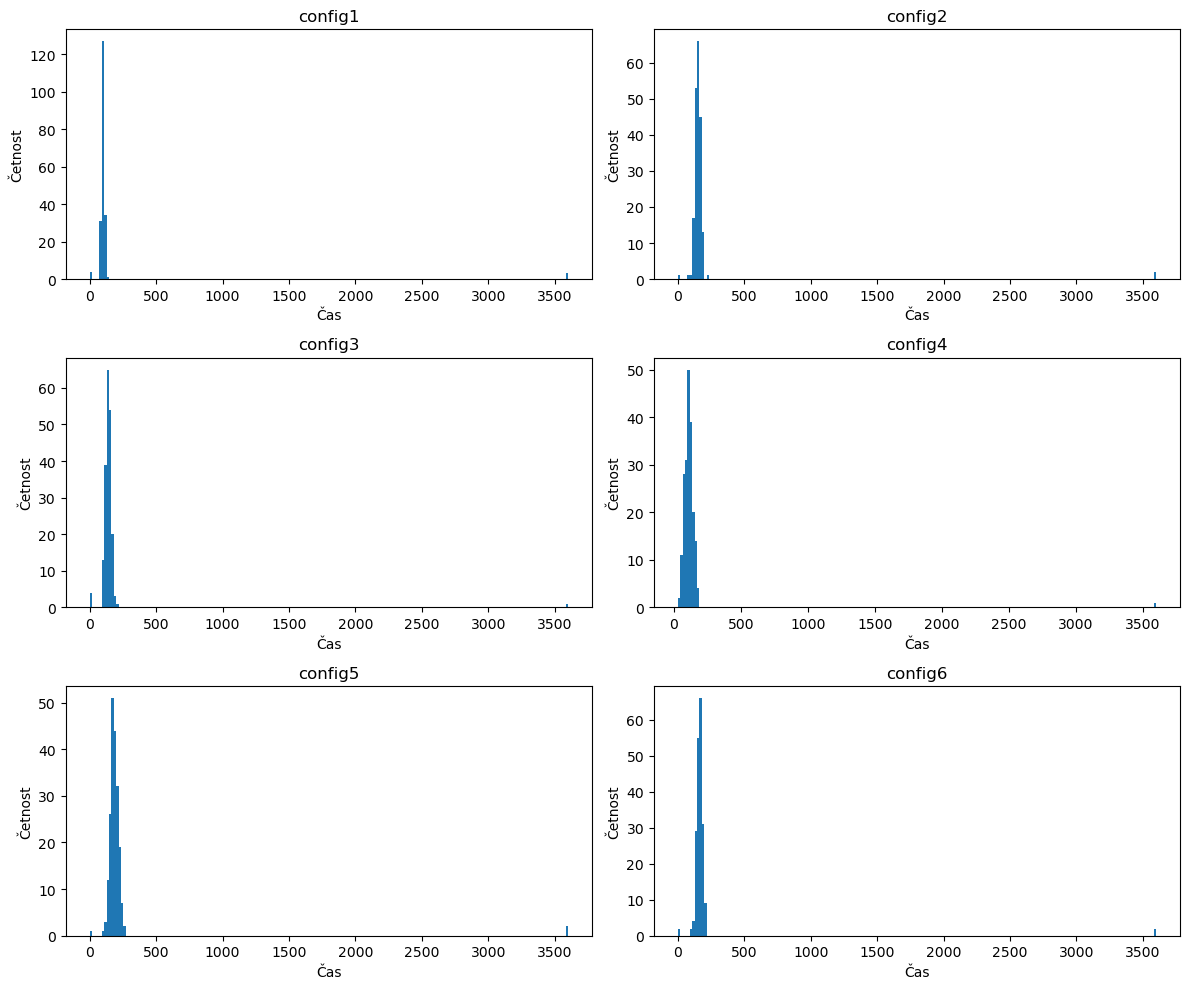

In [4]:
plt.figure(figsize=(12,10))
for figid, (conf, d) in enumerate(df.groupby("conf")):
    ax = plt.subplot(321 + figid)
    ax.hist(d["time"], label=conf, bins=200)
    ax.set_title(conf)
    ax.set(xlabel="Čas", ylabel="Četnost")

plt.tight_layout()
###################

xlim_val = plt.xlim() # Uložení xlim hodnot (min, max) pro zobrazení grafů po odstranění chybných dat.

__OTÁZKA K DOPLNĚNÍ:__

_Objevily se nějaké chybné hodnoty? Proč tam jsou s ohledem na to, že se jedná o běhy algoritmů?_

Ano. V datech jsou uloženy také chybné hodnoty. Konkrétně lze označit hodnoty času (time) 0.01 a 3600 pro jednotlivé běhy (run) konfigurací (conf) za chybné.

<u>Hodnota 0.01</u>:

Zaprvé četnost zastoupení této časové hodnoty v datech je oproti ostatním hodnotam minimální. Zároveň tato časová hodnota je velmi _malá_ oproti dalším časovým hodnotám a hodnoty jí blízké nejsou v datech jinak zastoupeny.

Na základě skutečnosti, data zachycují jednotlivé běhy algoritmů se s největší pravděpodobností jedná o ukončení programu s chybovým stavem, tudíž celý algoritmus nebyl proveden a byl předčasně ukončen. Při bližší analýze dat může být tato skutečnost potvrzena, že všechny běhy, jejichž čas odpovídal dané hodnotě, skončily s chybovým stavem SEGFAULT.

<u>Hodnota 3600</u>:

Zaprvé četnost zastoupení této časové hodnoty v datech je oproti ostatním hodnotam minimální. Zároveň tato časová hodnota je velmi _velká_ oproti dalším časovým hodnotám a hodnoty jí blízké nejsou v datech jinak zastoupeny.

Na základě skutečnosti, data zachycují jednotlivé běhy algoritmů se s největší pravděpodobností jedná o ukončení programu na základě překročení času omezujícího dobu povolenou pro běh algoritmu (timeout) a došlo k nevalidnímu ukončení co se týče běhu algoritmu. Při bližší analýze dat může být tato skutečnost potvrzena, že všechny běhy, jejichž čas odpovídal dané hodnotě, s chybovým stavem TIME LIMIT.

Vyčistěte dataframe `df` tak, aby tam tyto hodnoty nebyly a ukažte znovu analýzu toho, že čištění dat bylo úspěšné. Odtud dále pracujte s vyčištěným datasetem.

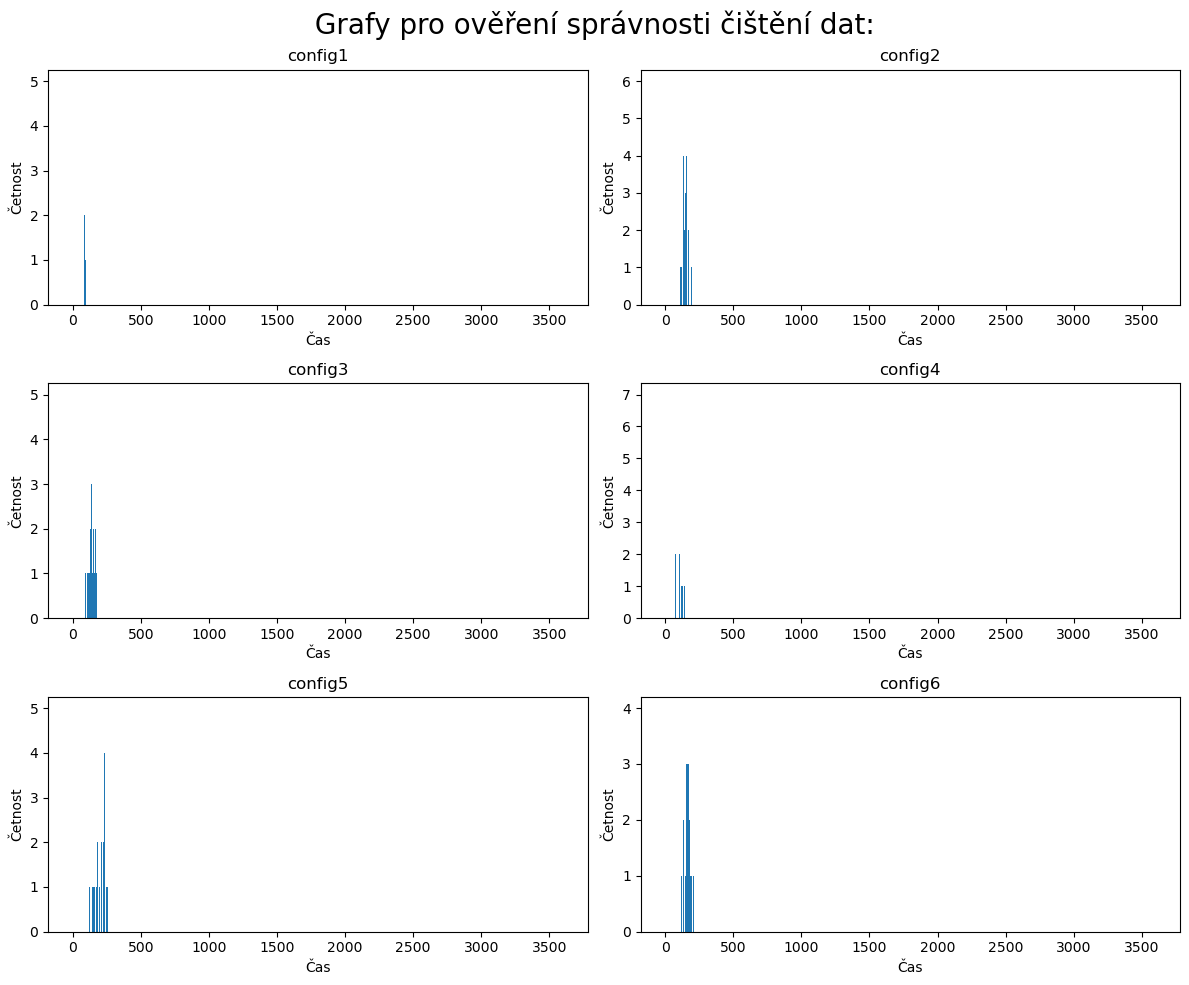

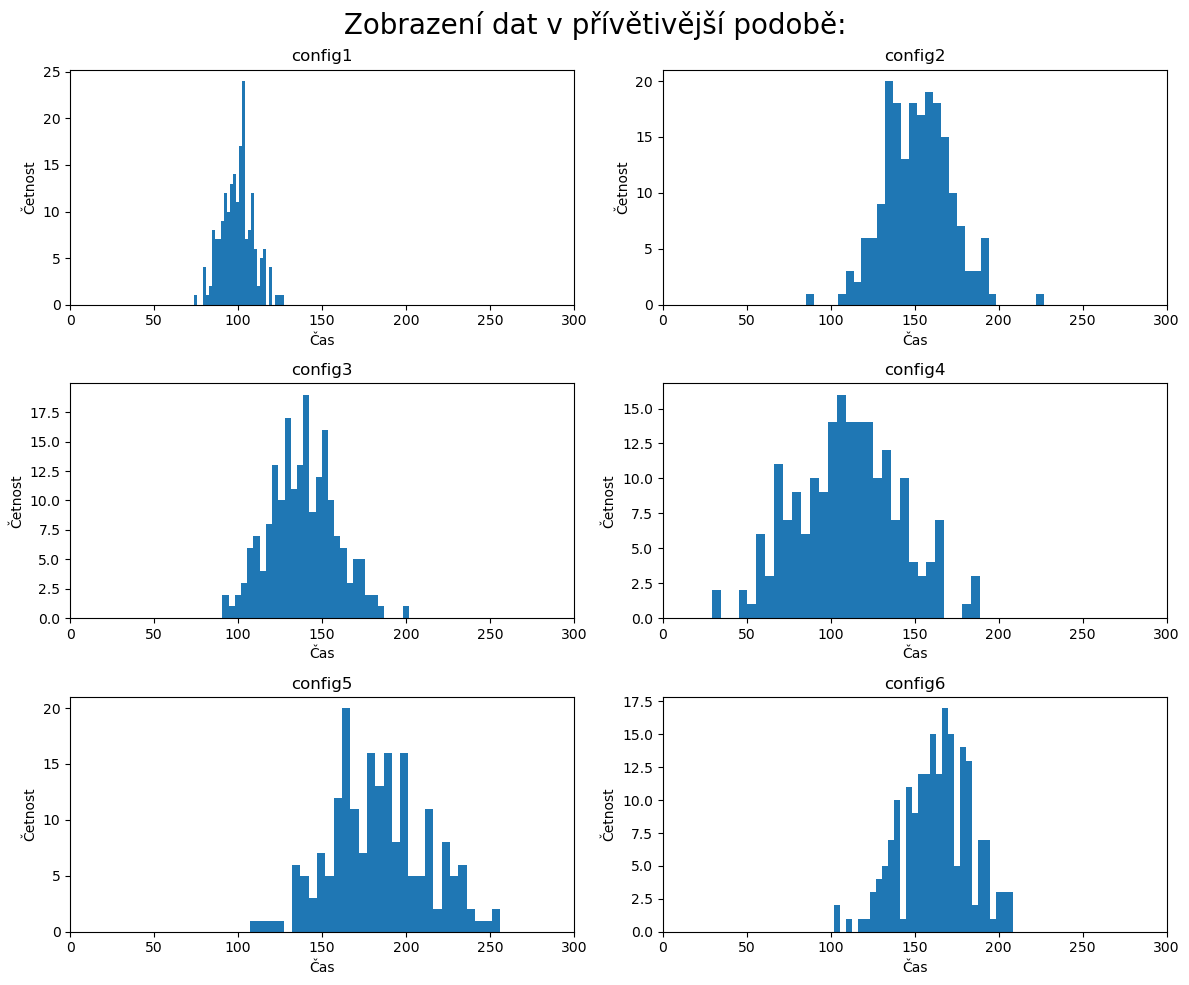

In [5]:
# TODO kod pro upravu dataframe tak, že tam tyto hodnoty nebudou:

# Vyčištění chybných hodnot (0.01 a 3600)
df = df[(df.time > 0.01) & (df.time < 3600)]

# Znovuvykreslení dat    
plt.figure(figsize=(12,10))
plt.suptitle(" Grafy pro ověření správnosti čištění dat: ", fontsize=20)
for figid, (conf, d) in enumerate(df.groupby("conf")):
    ax = plt.subplot(321 + figid)
    ax.hist(d["time"], label=conf, bins=200)
    ax.set_title(conf)   
    ax.set(xlabel="Čas", ylabel="Četnost")
    ax.set_xlim(xlim_val)

plt.tight_layout()

plt.figure(figsize=(12,10))
plt.suptitle(" Zobrazení dat v přívětivější podobě: ", fontsize=20)
for figid, (conf, d) in enumerate(df.groupby("conf")):
    ax = plt.subplot(321 + figid)
    ax.hist(d["time"], label=conf, bins=30)
    ax.set_title(conf)
    ax.set(xlabel="Čas", ylabel="Četnost")
    ax.set_xlim(0, 300)

plt.tight_layout()


## Deskriptivní popis hodnot
Vypište pro jednotlivé konfigurace základní deskriptivní parametry času pro jednotlivé konfigurace.  

__TIP__ pokud výsledky uložíte jako Pandas DataFrame, zobrazí se v tabulce.

In [14]:
# TODO deskriptivni parametry
df_grouped = df.groupby("conf")["time"]

print("Koeficient šikmosti")
print("###################")
print(df_grouped.skew())
print()

print("Koeficient špičatosti")
print("###################")
print(df_grouped.apply(pd.DataFrame.kurt))
print()

print("Další základní deskriptivní parametry")
print("###################")
df_grouped.describe()

Koeficient šikmosti
###################
conf
config1    0.141701
config2    0.174196
config3    0.153763
config4    0.049205
config5    0.100871
config6   -0.241516
Name: time, dtype: float64

Koeficient špičatosti
###################
conf
config1    0.022038
config2    0.804491
config3   -0.067742
config4   -0.130768
config5   -0.226912
config6    0.014161
Name: time, dtype: float64

Další základní deskriptivní parametry
###################


,count,mean,std,min,25%,50%,75%,max
conf,,,,,,,,
config1,193.0,99.590413,9.386788,73.802549,92.979469,99.865028,104.824724,127.201692
config2,197.0,151.732975,19.833198,85.174653,137.995662,151.516091,163.802880,227.054630
config3,195.0,138.616959,19.867428,90.567110,124.803901,138.678404,151.536291,201.577616
config4,199.0,110.317016,30.656816,29.093401,88.742158,110.782732,130.665606,188.971462
config5,197.0,183.659767,28.729836,107.283620,164.070091,183.843132,201.250693,255.807973
config6,196.0,162.829359,20.648193,102.074892,149.917475,163.990098,177.730865,208.795048


__OTÁZKA K DOPLNĚNÍ:__

_Okomentujte, co všechno můžeme z parametrů vyčíst._

TODO dopsat
Moje pozn.: nulová šikmost a špičatost naznačuje, že se jedná o normální rozložení.

## Vizualizace
Vizualizujte časy běhů algoritmů v jednom kompaktním grafu tak, aby byl zřejmý i rozptyl hodnot. Zvolte vhodný graf, který pak níže komentujte.

Text(0.5, 1.0, 'Časy běhů algoritmů')

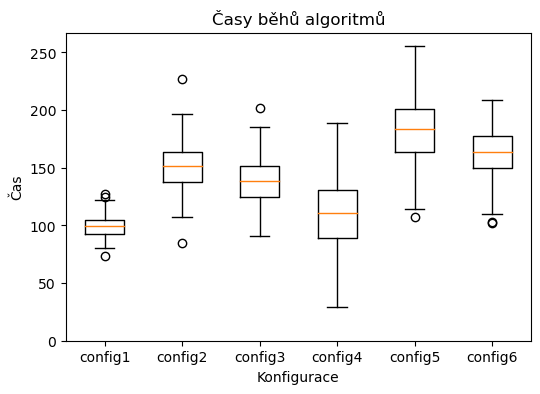

In [17]:
# TODO graf

fig, ax = plt.subplots(figsize=(6, 4))

ax.boxplot(df.groupby("conf")["time"].apply(list), labels=df.conf.unique())
ax.set(xlabel="Konfigurace", ylabel="Čas", ylim=(0, None))
ax.set_title("Časy běhů algoritmů")

__OTÁZKA K DOPLNĚNÍ:__

_Okomentujte  výsledky z tabulky._

Pozn. na základě velikosti boxu pro config1 a config4 lze tvrdit, že mají rozdílný rozptyl (variance) - welch test

https://www.statology.org/equal-variance-assumption/

## Určení efektivity konfigurací algoritmů
Nás ale zajímá, jaká konfigurace je nejrychlejší. Z výše vykresleného grafu můžeme vyloučit některé konfigurace. Existuje tam však minimálně jedna dvojice, u které nedokážeme jednoznačně určit, která je lepší - pokud nebudeme porovnávat pouze extrémní hodnoty, které mohou být dané náhodou, ale celkově. Proto proveďte vhodný test významnosti - v následující části diskutujte zejména rozložení dat (i s odkazem na předchozí buňky, variabilitu vs polohu a podobně). Je nutné každý logický krok a výběry statistických funkcí komentovat. Můžete i přidat další buňky.

Vužijte vhodnou funkci z knihovny `scipy.stats` a funkci poté __implementujte sami__ na základě základních matematických funkcí knihovny `numpy` případně i funkcí pro výpočet studentova rozložení v [scipy.stats](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html). Při vlastní implementaci není nutné se primárně soustředit na efektivitu výpočtu (není potřeba využít všechny funkce numpy, můžete použít normální cykly a podobně - v hodnocení však bude zahrnuta přehlednost a neměly by se objevit jasné chyby, jako je zvýšení třídy složitosti a podobně).

__OTÁZKA K DOPLNĚNÍ:__

_Jaká data budete zkoumat? Jaké mají rozložení a parametry (např. varianci) a jaký test použijete? Jaká je nulová hypotéza? Jak se liší variabilita a poloha vybraných konfigurací?_

TODO doplnit

In [76]:
# TODO: Implementace s vyuzitim knihovni funkce
# pozn dvojice 1 a 4

config_1 = df[(df.conf == "config1")]["time"]
config_4 = df[(df.conf == "config4")]["time"]

# todo jestli two-sided, less nebo greater
stats.ttest_ind_from_stats(config_1.mean(), config_1.std(), len(config_1), config_4.mean(), config_4.std(), len(config_4), equal_var=False)

Ttest_indResult(statistic=-4.653742937859716, pvalue=4.473404490955135e-06)

__OTÁZKA K DOPLNĚNÍ:__

_Jaký je závěr statistického testu?_

In [75]:
# TODO vlastni implementace zvoleneho testu

# def independent_two_sample_ttest():
# def welchs_ttest():

def own_ttest_ind_from_stats(mean_1, std_1, nobs_1, mean_2, std_2, nobs_2,
                             equal_var=True, alternative="two-sided"):
    mean_1 = np.asarray(mean_1)
    std_1 = np.asarray(std_1)
    mean_2 = np.asarray(mean_2)
    std_2 = np.asarray(std_2)

    # TODO rozdeleni equal var nebo ne equal var
    
    #########################
    # equal var ttest denom - TODO
    #########################
    # https://en.wikipedia.org/wiki/Student%27s_t-test#Independent_two-sample_t-test
    
    
    s_1 = std_1**2
    s_2 = std_2**2
    
    s_1 = np.where(nobs_1 == 1, 0, s_1)[()]
    s_2 = np.where(nobs_2 == 1, 0, s_2)[()]
    
    df = nobs_1 + nobs_2 - 2.0
    svar = ((nobs_1 - 1) * s_1 + (nobs_2 - 1) * s_2) / df
    divisor = np.sqrt(svar * (1.0 / nobs_1 + 1.0 / nobs_2))                          
                      
    
    #########################
    
    #########################
    # unequal var ttest denom - Welch Test
    #########################
    # https://en.wikipedia.org/wiki/Welch%27s_t-test
    '''
    s_1 = std_1**2
    s_2 = std_2**2
    
    sn_1 = s_1 / nobs_1
    sn_2 = s_2 / nobs_2
    
    # TODO osetrit chybovy stav, jak maji oni
    v = (sn_1 + sn_2)**2 / (sn_1**2 / (nobs_1 - 1) + sn_2**2 / (nobs_2 - 1))
    
    # TODO jeste osetrit asi, co tam delaji oni
    
    df = v
    divisor = np.sqrt(sn_1 + sn_2)    
    '''
    #########################
    
    diff = (mean_1 - mean_2)
    
    # TODO osetreni chybovyho stavu jak maj oni asi
    
    t = np.divide(diff, divisor)    
    
    if alternative == "two-sided":
        p_value = stats.t.cdf(-np.abs(t), df)*2
    elif alternative == "less":
        p_value = stats.t.cdf(t, df)        
    elif alternative == "greater":
        p_value = stats.t.cdf(-t, df)   
    #else:
        # TODO error
    
    if t.ndim == 0:
        t = t[()]
    if p_value.ndim == 0:
        p_value = p_value[()]
    
    return t, p_value
    
    
t, p_value = own_ttest_ind_from_stats(config_1.mean(), config_1.std(), len(config_1), config_4.mean(), config_4.std(), len(config_4), equal_var=False)

print("statistic =", t)
print("pvalue =", p_value)

statistic = -4.653742937859716
pvalue = 4.473404490955135e-06
